In [1]:
import numpy as np
import matplotlib.pyplot as plt

import data
import data.getSyntheticData as SyntheticData

from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.svm import OneClassSVM
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import precision_score, recall_score, roc_curve

from sklearn.kernel_approximation import Nystroem

from models.OCSMM import OCSMM
from utils.gridSearch import *
from utils.Nystroem_SMM import Nystroem_SMM

import pickle
import itertools


In [2]:
def compute_kernel(X, sigma):
    K = np.zeros((len(X), len(X)))
    rbf = RBF(length_scale=sigma)
    for (i, j) in itertools.combinations(range(len(X)), 2):
            kernel = rbf(X[i], X[j])
            n = X[i].shape[0]
            K[i, j] = np.sum(np.sum(kernel, axis=0), axis=0) / (n ** 2)
            K[j, i] = K[i, j]
    return K

def compute_cross_kernel(X, Y, sigma):
    K = np.zeros((len(X), len(Y)))
    rbf = RBF(length_scale=sigma)
    for (i, j) in itertools.product(range(len(X)), range(len(Y))):
            kernel = rbf(X[i], Y[j])
            n_i = X[i].shape[0]
            n_j = Y[j].shape[0]
            K[i, j] = np.sum(np.sum(kernel, axis=0), axis=0) / (n_i * n_j)
    return K

In [3]:
# Experiment plots
def plot_synthetic_data(Stest, scores):
    scores = np.squeeze(scores)
    score_plot = [np.array([sc]*Stest[idx].shape[0]) for idx, sc in enumerate(scores)]
    mini, maxi = -2.5, 2.5
    norm = plt.Normalize(mini, maxi)
    
    fig, axes = plt.subplots(2, 6, figsize=(15, 4.5), sharey=True)
    idx=0
    for ax in axes.flat:
        ax.scatter(Stest[idx][:,0], Stest[idx][:,1], 
                         c=score_plot[idx], cmap='viridis', norm=norm)
        idx+=1
        
    for a, color in zip([axes[1][9%6], axes[1][10%6], axes[1][11%6]], ['green', 'red', 'purple']):
        plt.setp(a.spines.values(), color=color, ls=':')
        plt.setp([a.get_xticklines(), a.get_yticklines()], color=color, ls=':')
    
    fig.tight_layout()
    fig.colorbar(plt.gca().get_children()[0], ax=axes.ravel().tolist()).set_label('Anomaly Score')
#     plt.savefig('synth_data.png')
    plt.show()

def plot_roc_curve(scores, Ytest):
    # Receives trained clasiffier and plots its roc curve
    # Against Test Set.
    p_values = empirical_p_values(scores)
    auc, best_cut, roc_curve = roc_auc(Ytest, p_values)
    plt.plot(roc_curve[:,0], roc_curve[:,1])
    plt.savefig('PR.png')
    plt.show()
    

In [ ]:
# Generate Synthetic Data
Strain = SyntheticData.genSyntheticTrainData(n_sample=100, n_sets=50)

Stest = SyntheticData.genSyntheticTrainData(n_sample=100, n_sets=9)
X_anomaly1 = np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.identity(2), size=100)
# X_anomaly2 = np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.identity(2), size=100)
# X_anomaly3 = np.random.multivariate_normal(mean = [0.0, 0.0], cov = np.identity(2), size=100)
X_anomaly2 = SyntheticData.genSyntheticSet(100, pmix=[0.33, 0.33, 0.33], sigma_c = 0.2)
X_anomaly3 = SyntheticData.genSyntheticSet(100, pmix=[0.33, 0.33, 0.33], sigma_c = 0.2)
Stest.extend([X_anomaly1, X_anomaly2, X_anomaly3])

Ytest = [1] * 9 + [-1] * 3

In [4]:
# Higgs-Boson data

Strain = pickle.load(open('HiggsStrain.pkl', 'rb'))
Stest = pickle.load(open('HiggsStest.pkl', 'rb'))
Ytest = pickle.load(open('HiggsYtest.pkl', 'rb'))
Ytest = [1 - 2 * y for y in Ytest]
print(len(Strain))
print(len(Stest))

Strain.extend(Stest)

100
120


In [7]:
precision = np.zeros((10, 10))
recall = np.zeros((10, 10))
for i, sigma in enumerate([0.1 * i for i in range(1, 2)]):
    K = compute_kernel(Strain, sigma)
    for j, nu in enumerate([0.1 * i for i in range(1, 2)]):
        ocsmm = OneClassSVM(kernel='precomputed', nu=nu)
        Ypred_train = ocsmm.fit_predict(K)
        scores_train = ocsmm.decision_function(K)

print(scores_train)
# fpr, tpr, th = roc_curve(Ytest, scores)
# plt.plot(fpr, tpr)
# plot_synthetic_data(Stest, -100 * scores)
# plot_synthetic_data(Strain[38:50], -100 * scores_train[38:50])
# fpr, tpr, th = roc_curve([1] * 47 + [-1] * 3, scores_train)
# plt.plot(fpr, tpr)
# print(scores_train)

[ 3.26610904e-03 -7.24038765e-04 -1.24831815e-03 -1.14143467e-03
  6.65262132e-03 -1.33379029e-03  1.16966154e-02 -3.34619749e-04
  7.02282239e-03 -1.63540173e-03  4.75559308e-03  1.56919381e-03
  1.05686089e-04  1.90498491e-03  7.16647611e-04  8.03413644e-04
  1.88198253e-03  7.32476463e-03  2.95765176e-03  2.82311846e-03
  3.31151072e-03  5.37329685e-03  3.26844716e-04  3.62700748e-03
  3.40043984e-03  1.14240653e-03  1.45071196e-03  9.21870980e-04
  1.33145794e-03  1.07568308e-03  6.21368036e-04  2.08453649e-03
  8.65434088e-04  6.55782942e-03  4.05756799e-03  3.77883108e-03
  2.66199934e-03  9.33184146e-04  2.83789211e-04  4.51972896e-03
  2.12842108e-03  4.22991481e-03  2.34553247e-03 -1.51440031e-03
  3.17415988e-04  3.08367637e-03  2.03953307e-03  3.14973226e-04
  9.02887971e-04  4.91215268e-03 -1.52244909e-03  4.94530322e-04
  2.67914787e-03  5.24794443e-04 -1.16053730e-03  1.86485246e-03
  2.93963643e-03  2.97705843e-03  1.37195762e-03  5.05219968e-03
  3.50296616e-04  5.85708

In [8]:
print(Ypred_train)

[ 1 -1 -1 -1  1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1]


In [ ]:
print(len(Strain))

In [ ]:
plt.figure()
plt.plot(recall[1, :-1], precision[1, :-1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('PR.png')

In [20]:
# Generate Synthetic Data 2
Strain = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=50)
Stest = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=47)
X_anomaly1 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=1)
X_anomaly2 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=2)
X_anomaly3 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=3)
Stest.extend([X_anomaly1, X_anomaly2, X_anomaly3])
Ytest = [1] * 47 + [-1] * 3

In [31]:
# Fast OCSMM

n_components = 10
sigma = 0.1
nyst = Nystroem_SMM(kernel=compute_cross_kernel, kernel_params=sigma, n_components=n_components)
nyst.fit(np.array(Strain))
data_transformed = nyst.transform(np.array(Stest))
ocsvm = OneClassSVM(kernel='linear', nu=0.1)
Ypred = ocsvm.fit_predict(data_transformed)

In [32]:
print(Ypred)

[ 1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1
 -1 -1]


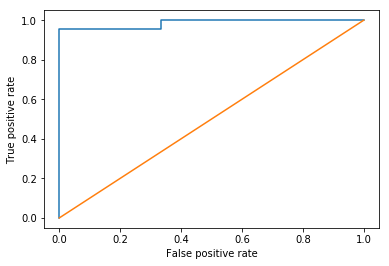

In [33]:
scores = ocsvm.decision_function(data_transformed)
fpr, tpr, th = roc_curve([1] * 47 + [-1] * 3, scores)
plt.plot(fpr, tpr)
plt.plot([0.2 * i for i in range(0, 6)], [0.2 * i for i in range(0, 6)])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.savefig('ROC.png')

In [34]:
print(scores)

[ 4.30075520e-03  5.77937419e-03  2.90943082e-03  1.68919950e-03
  2.80472099e-03  2.07900004e-03  8.84971023e-03  6.03265636e-04
  3.00836566e-03 -1.87815755e-04  6.00280003e-03  5.68491869e-03
  1.19262283e-03  1.01141546e-02  2.35456244e-03  6.24114027e-03
  4.75883313e-03  3.70497590e-03  4.18455690e-03  2.49669421e-03
  2.92894404e-03  2.27358968e-03  2.54382064e-03  7.87602040e-03
 -4.98405378e-05  2.76257418e-03  4.83959139e-03  1.04689286e-02
  6.21286095e-03  1.90069774e-02  4.69278693e-03  1.87361826e-03
  3.87941646e-03  1.85164226e-03  7.56559293e-03  1.11841452e-03
  1.94852840e-04  3.09176252e-03  1.98547575e-03  3.75631172e-04
  6.45981225e-03 -3.07322943e-04  2.32087529e-03  4.48960736e-03
  3.03592049e-03  8.83595167e-03  5.65919982e-03 -1.15509247e-03
 -4.11360246e-03 -1.87815333e-04]


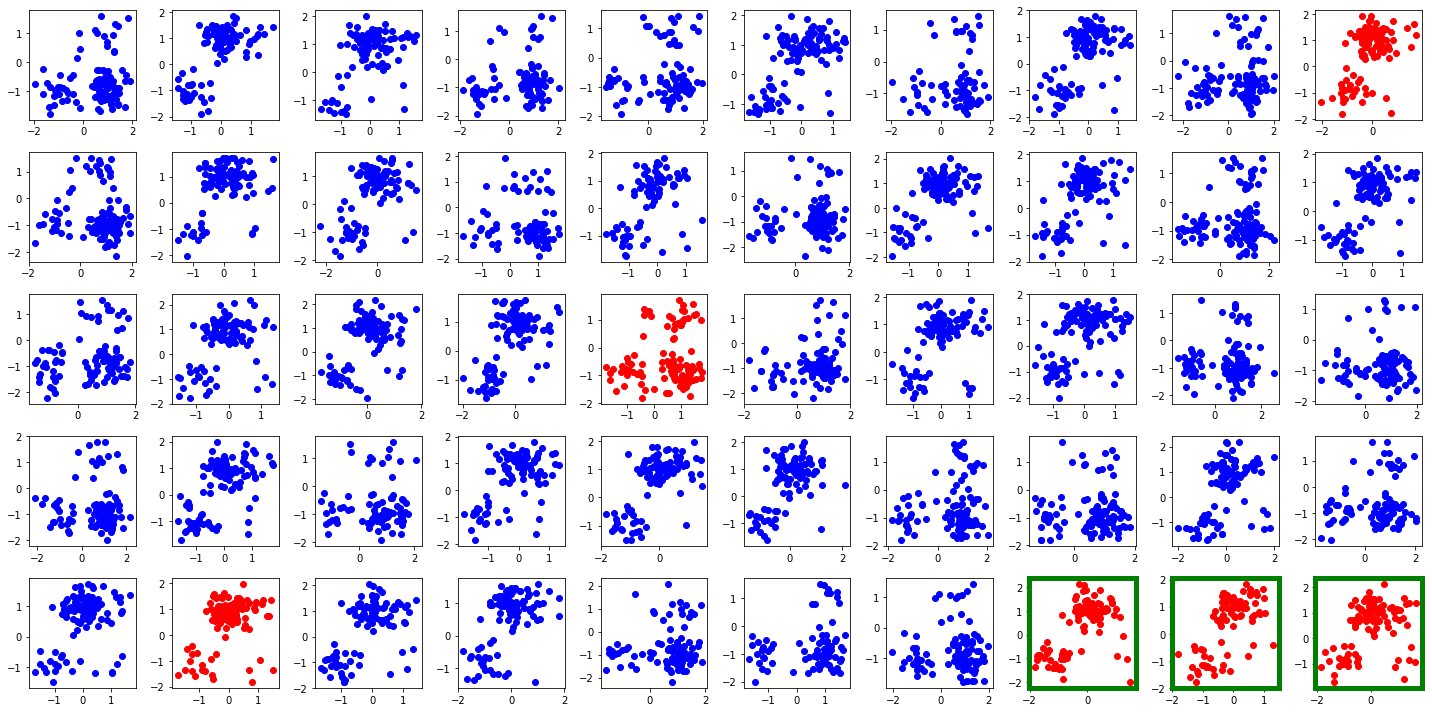

In [35]:
from matplotlib import spines

plt.figure(figsize=(20,10))
for i in range(50):
    ax = plt.subplot(5, 10, i + 1)
    c = 'b'
    if Ypred[i] == -1:
        c = 'r'
    if i > 46:
        ax.spines['bottom'].set_color('green')
        ax.spines['bottom'].set_linewidth(5)
        ax.spines['top'].set_color('green')
        ax.spines['top'].set_linewidth(5)
        ax.spines['right'].set_color('green')
        ax.spines['right'].set_linewidth(5)
        ax.spines['left'].set_color('green')
        ax.spines['left'].set_linewidth(5)
    plt.scatter(Strain[i][:, 0], Strain[i][:, 1], c=c)
plt.tight_layout()
plt.savefig('scatter.png')

In [ ]:
import time

n_list = [10, 20, 30, 40, 50, 60, 70, 80]
base_time = []
bootstrap_time = []
for n in n_list:

    # Generate Synthetic Data 2
    Strain = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=n)

    Stest = SyntheticData.genSyntheticTrainData_1(n_sample=100, n_sets=n-3)
    X_anomaly1 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=1)
    X_anomaly2 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=2)
    X_anomaly3 = SyntheticData.genSyntheticSet_1(100, pmix=[0.61, 0.1, 0.06, 0.23], seed=3)
    Stest.extend([X_anomaly1, X_anomaly2, X_anomaly3])

    Ytest = [1] * (n - 3) + [-1] * 3
    Ytrain = [1] * n

    start_time = time.time()
    base_fpr, base_tpr, base_auc = base_roc2(Strain, Ytrain, Stest, Ytest)
    base_time.append(time.time() - start_time)
    start_time = time.time()
    mean_fpr, tprs, aucs = boostrap_roc2(Strain, Ytrain, Stest, Ytest, [0])
    bootstrap_time.append(time.time() - start_time)

plt.plot(n_list, base_time, linestyle='--', label='OCSMM')
plt.plot(n_list, bootstrap_time, label='Fast OCSMM')
plt.legend()
plt.xlabel('number of clusters')
plt.ylabel('time in seconds')
plt.savefig('n_vs_time.png')